<a href="https://colab.research.google.com/github/ovais6/C/blob/master/Ad_price_strategy_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name:** Dr. Ovais Bashir Gashroo

**Position:** Executive Data Scientist

**Round - 2:** Modelling Exercise

**Email Id:** ovaisgashru@gmail.com

**Mobile No.:** +91 7042670564


---



# **Initialize**

**INTRODUCTION:**
60% of the digital ad inventory is sold by publishers in Real Time first price Auctions. Once a user lands on a webpage, bidders (advertisers) bid for different ad slots on the page and the one with the highest winning bid displays their ad in the ad space and pays the amount he bid. This process encourages bid shading – bidding lesser than the perceived value of the ad
space to maximize utilization for self while maintaining a particular win rate at lowest prices. Hence, for publishers, it becomes important to value their inventory (all the users that visit their website * all the ad slots they have on their websites) correctly so that a reserve price, or a minimum price can be set up for the auctions.

**PROBLEM STATEMENT:**
In a first price auction, the highest bidder wins and pays the price they bid if it exceeds the reserve price. The optimal strategy of a bidder is to shade their bids (bid less than their true value of the inventory). However, bidder needs to win a certain amount to achieve their goals. This suggests they need to shade as much possible while maintaining a certain win rate. A bidder perceives a certain value out of every impression they win. Each bidder would like to maintain the value they derived out of this set of websites (given in the dataset) in June with a maximum deviation of 20%. Setting a reserve price induces this by causing bidders to lose at lower bids which encourages higher bidding and more publisher revenue. However, since most of these takes place through automated systems, there might be an unknown delay in setting reserve prices & reducing win rate of bidder & bidder changing their bid shading algorithm & increased publisher revenue.

**Questions**

What are the reserve prices that he/she can set?

What is the potential revenue range our publisher can make in July?

**1. Import necessary libraries**

In [ ]:
# Data representation and computation
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:20,.4f}'.format

# Graph plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data splitting, feature engg., and pipeline to train machine learning models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import cluster, silhouette_score, v_measure_score, adjusted_rand_score, completeness_score

# Machine learning models
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Miscellaneous
import warnings
from math import log, e, ceil
from scipy.stats import entropy
from prettytable import PrettyTable

# Declaration
warnings.filterwarnings('ignore')
%precision 2
%matplotlib inline
sns.set(font_scale=1)

**2. Load Data**

In [ ]:
# The data is of a particular month and the number of impressions that happened in that month.
# To read the data as a time series, we have to pass special arguments to the read_csv command:
from datetime import datetime # Import the datetime class from the standard datetime module
# Update the date format string to match the actual data format (DD/MM/YYYY HH:MM)
dateparse = lambda dates: datetime.strptime(dates, '%d/%m/%Y %H:%M')

ldf_ad_data = pd.read_csv('Ascendeum_Dataset2.csv', parse_dates=['date'], date_parser=dateparse)
ldf_ad_data.head()

,date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,integration_type_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent
0,2019-06-30,351,10,187,2,84,3473,19,60,1,4,5174,16,0.0000,2,16,1
1,2019-06-30,351,10,187,2,84,3473,19,58,1,4,5174,6,0.0000,0,6,1
2,2019-06-30,351,10,147,2,84,3473,19,60,1,4,5174,4,0.0000,0,4,1
3,2019-06-30,351,10,147,2,84,3473,19,58,1,4,5174,4,0.0000,0,4,1
4,2019-06-30,348,10,147,3,79,3463,20,59,1,19,5138,4,0.0000,0,4,1


**3. Data Preprocessing:** Here we'll quickly describe a dataset; the number of rows/columns, missing data, data types, preview, etc.

In [ ]:
ldf_ad_data.shape

(567291, 17)

In [ ]:
ldf_ad_data.describe()

,date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,integration_type_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent
count,567291,"567,291.0000","567,291.0000","567,291.0000","567,291.0000","567,291.0000","567,291.0000","567,291.0000","567,291.0000","567,291.0000","567,291.0000","567,291.0000","567,291.0000","567,291.0000","567,291.0000","567,291.0000","567,291.0000"
mean,2019-06-15 16:43:33.515814656,347.1078,10.2206,110.2261,1.8997,262.0843,"1,951.2737",12.6321,57.2172,1.0000,14.4337,"5,136.4366",33.6737,0.0697,12.8383,32.1528,1.0000
min,2019-06-01 00:00:00,342.0000,10.0000,1.0000,1.0000,8.0000,45.0000,3.0000,15.0000,1.0000,1.0000,"5,050.0000",0.0000,-0.1542,0.0000,0.0000,1.0000
25%,2019-06-08 00:00:00,345.0000,10.0000,39.0000,1.0000,79.0000,45.0000,4.0000,56.0000,1.0000,4.0000,"5,099.0000",0.0000,0.0000,0.0000,0.0000,1.0000
50%,2019-06-16 00:00:00,346.0000,10.0000,122.0000,2.0000,88.0000,"3,438.0000",11.0000,57.0000,1.0000,19.0000,"5,127.0000",2.0000,0.0000,0.0000,2.0000,1.0000
75%,2019-06-23 00:00:00,350.0000,10.0000,183.0000,3.0000,139.0000,"3,460.0000",19.0000,58.0000,1.0000,19.0000,"5,168.0000",6.0000,0.0054,2.0000,6.0000,1.0000
max,2019-06-30 00:00:00,351.0000,17.0000,308.0000,5.0000,"2,646.0000","3,489.0000",20.0000,60.0000,1.0000,21.0000,"5,443.0000","14,452.0000",83.8220,"7,392.0000","13,756.0000",1.0000
std,NaN,2.9304,1.2229,66.1778,0.7920,627.3255,"1,652.5457",6.8126,1.9560,0.0000,7.1359,62.5086,220.8654,0.7136,101.9892,207.0965,0.0000


In [ ]:
ldf_ad_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567291 entries, 0 to 567290
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date                     567291 non-null  datetime64[ns]
 1   site_id                  567291 non-null  int64         
 2   ad_type_id               567291 non-null  int64         
 3   geo_id                   567291 non-null  int64         
 4   device_category_id       567291 non-null  int64         
 5   advertiser_id            567291 non-null  int64         
 6   order_id                 567291 non-null  int64         
 7   line_item_type_id        567291 non-null  int64         
 8   os_id                    567291 non-null  int64         
 9   integration_type_id      567291 non-null  int64         
 10  monetization_channel_id  567291 non-null  int64         
 11  ad_unit_id               567291 non-null  int64         
 12  total_impression

Before we proceed, let’s understand why we focus on measurable impressions instead of total impressions.

**Definitions:**

**Total Impressions:** The total number of impressions recorded for a given set of dimensions.

**Measurable Impressions:** The number of impressions that could be measured by Active View. These are a subset of total impressions and typically represent almost all eligible impressions. Some impressions, such as those in cross-domain iframes, may not be measurable.

**Viewable Impressions:** The number of measurable impressions that were actually viewable. An ad is considered viewable if at least 50% of its area was on screen for at least one second.

**Explanation:**

Total impressions represent the entire set, including both measurable and non-measurable impressions. Measurable impressions are the successful, trackable ones within that set. That’s why we prefer measurable impressions—they offer a more accurate basis for analysis and comparison.

In [ ]:
ldf_ad_data.isna().sum()

,0
date,0
site_id,0
ad_type_id,0
geo_id,0
device_category_id,0
advertiser_id,0
order_id,0
line_item_type_id,0
os_id,0
integration_type_id,0


In [ ]:
# consider total impression is 100%

impression_stats = PrettyTable()
impression_stats.field_names = ["Total","Viewable","Measurable"]
impression_stats.align[""] = "r"
impression_stats.add_row(["100%",
                          "%.2f"%((sum(ldf_ad_data['viewable_impressions'])/sum(ldf_ad_data['total_impressions']))*100),
                          "%.2f"%((sum(ldf_ad_data['measurable_impressions'])/sum(ldf_ad_data['total_impressions']))*100)])
print("Impression Report\n")
print(impression_stats)

Impression Report

+-------+----------+------------+
| Total | Viewable | Measurable |
+-------+----------+------------+
|  100% |  38.13   |   95.48    |
+-------+----------+------------+


**4. Dealing with outliers**

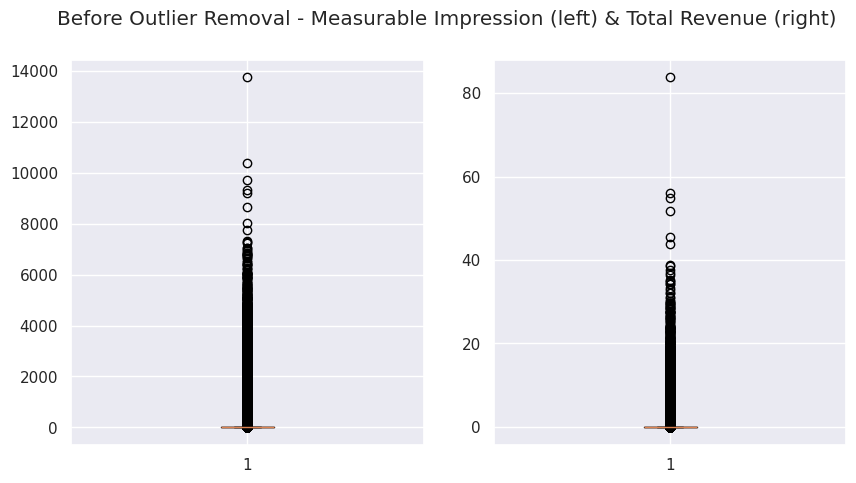

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('Before Outlier Removal - Measurable Impression (left) & Total Revenue (right)')
axs[0].boxplot(ldf_ad_data.measurable_impressions);
axs[1].boxplot(ldf_ad_data.total_revenue);

In [ ]:
#remove the outliers
ldf_ad_data = ldf_ad_data[ldf_ad_data['total_revenue'].between(ldf_ad_data['total_revenue'].quantile(.05), ldf_ad_data['total_revenue'].quantile(.95))]
ldf_ad_data = ldf_ad_data[ldf_ad_data['measurable_impressions'].between(ldf_ad_data['measurable_impressions'].quantile(.05), ldf_ad_data['measurable_impressions'].quantile(.95))]

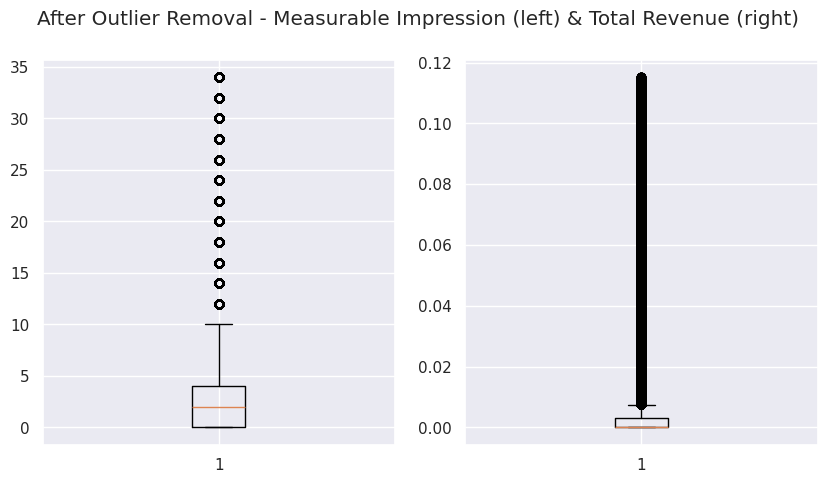

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('After Outlier Removal - Measurable Impression (left) & Total Revenue (right)')
axs[0].boxplot(ldf_ad_data.measurable_impressions);
axs[1].boxplot(ldf_ad_data.total_revenue);

Based on this information, we can identify certain features that are not relevant for our exploratory analysis, as noted in the documentation—for example, order_id, line_item_type_id, and revenue_share_percent. Additionally, since there are many features to consider, it's more effective to focus on those that provide meaningful insights. Therefore, we’ll remove the irrelevant ones from our analysis.

In [ ]:
shortlisted_columns = ['date',
 'site_id',
 'ad_type_id',
 'geo_id',
 'device_category_id',
 'advertiser_id',
 'os_id',
 'ad_unit_id',
 'total_impressions',
 'total_revenue',
 'viewable_impressions',
 'measurable_impressions']

ldf_ad_data = ldf_ad_data[shortlisted_columns]

**5. Exploratory Data Analysis (EDA)**

The purpose of this EDA is to find insights that will serve us later for Data cleaning/preparation/transformation which will ultimately be used into a neural network & machine learning algorithms.

In [ ]:
def plot_dual_graph(x, y1, y2, figsize = (15,7)):
    """
    This method is used to plot dual graph by accepting three params:
    :param1 - x = x-axis
    :param2 - y1 = y1-axis(left) - Calculate & Plot Mean
    :param3 - y2 = y2-axis(right) - Calculate & Plot count
    """
    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=figsize)

    ldf_avg_loss_amount_per_x =  ldf_ad_data.groupby(x)[y1].mean().to_frame(name = y1).reset_index()
    ldf_avg_claims_per_x =  ldf_ad_data.groupby(x)[y2].count().to_frame(name = y2).reset_index()
    ldf_day_wise = ldf_avg_loss_amount_per_x.merge(ldf_avg_claims_per_x)

    ldf_day_wise[[y2]].plot(kind = "bar", color=["c"], ax=axes, label="A")
    axes.set_ylabel("# "+str(y2), fontsize=15)
    axes.set_xlabel(x, fontsize=15)

    ax2 = axes.twinx()
    ax2.set_ylabel("Average "+str(y1), fontsize=15)
    ldf_day_wise[[y1]].plot(linestyle='-', marker='o', color=["r"], ax=ax2, label="B")

    plt.title(" & ".join(x)+" vs # "+str(y2)+" (left) & Average "+str(y1)+" (right)", fontsize=15)
    plt.grid(which='major', linestyle='-', linewidth='0.2', color='black')
    plt.show()

    return ldf_day_wise

**5.1 EDA of Date Variable**

In [ ]:
start_date = ldf_ad_data["date"].min()
end_date = ldf_ad_data["date"].max()

print("First date in dataset - "+str(start_date))
print("Last date in dataset - "+str(end_date))
print("No. of Days Present - "+str(end_date-start_date))

First date in dataset - 2019-06-01 00:00:00
Last date in dataset - 2019-06-30 00:00:00
No. of Days Present - 29 days 00:00:00


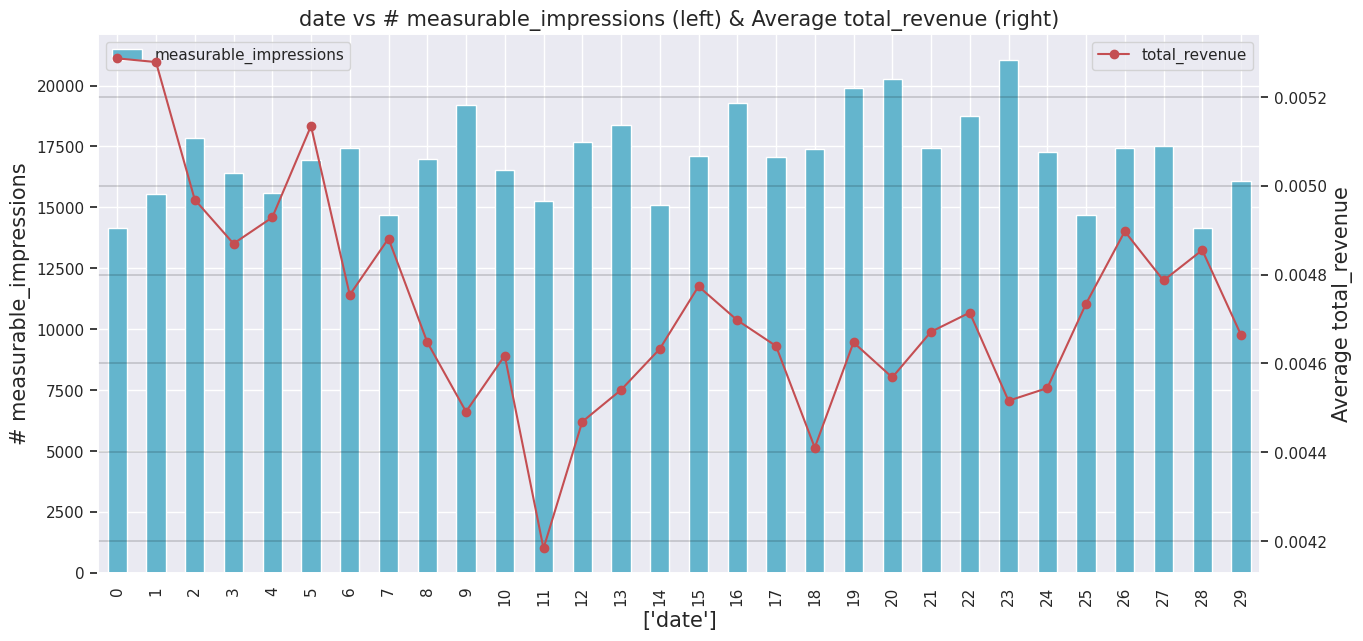

,date,total_revenue,measurable_impressions
0,2019-06-01,0.0053,14145
1,2019-06-02,0.0053,15550
2,2019-06-03,0.0050,17854
3,2019-06-04,0.0049,16416
4,2019-06-05,0.0049,15607
5,2019-06-06,0.0051,16933
6,2019-06-07,0.0048,17428
7,2019-06-08,0.0049,14697
8,2019-06-09,0.0046,16966
9,2019-06-10,0.0045,19191


In [ ]:
plot_dual_graph(x = ['date'], y1 = 'total_revenue', y2 = 'measurable_impressions', figsize=(15,7))

As observed above, both revenue amount and measurable impressions appear to be evenly distributed across the days of the month. However, to better understand the underlying patterns, we need to zoom in on the data. Let’s now examine the trends on a weekly basis.

**Week-wise**

Determine Week using iso calender & store them in WeekNo column

In [ ]:
ldf_ad_data["WeekNo"] = ldf_ad_data.apply(lambda x: x["date"].isocalendar()[1], axis=1)

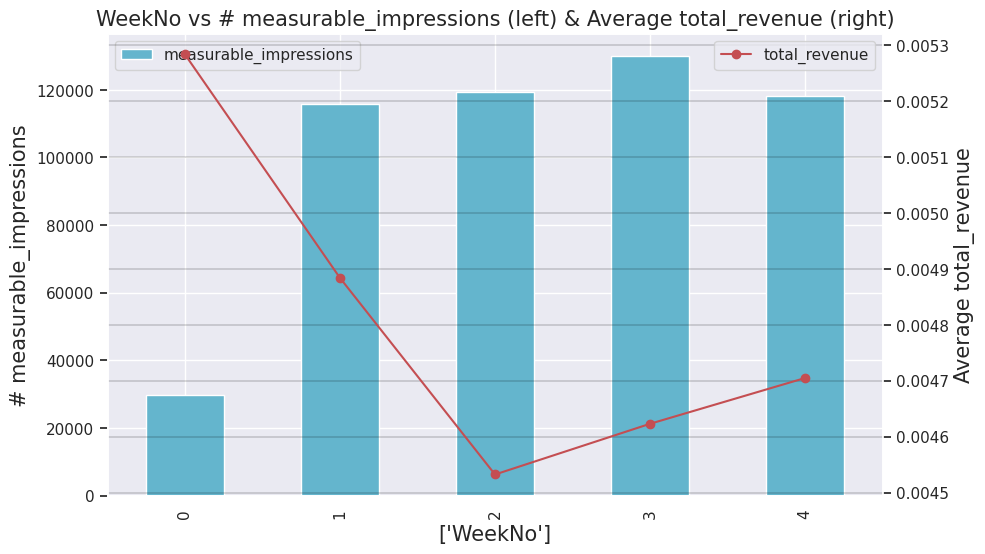

,WeekNo,total_revenue,measurable_impressions
0,22,0.0053,29695
1,23,0.0049,115901
2,24,0.0045,119233
3,25,0.0046,130109
4,26,0.0047,118231


In [ ]:
plot_dual_graph(x = ['WeekNo'], y1 = 'total_revenue', y2 = 'measurable_impressions', figsize=(10,6))

Once again, the revenue amount and measurable impressions appear to be evenly distributed throughout the month on a weekly basis. However, there may still be a trade-off between days and revenue and/or impressions—especially when comparing weekdays to weekends.

**Weekend-wise**

Let's calculate weekend day using datetime's weekday() method & store them in isWeekend column

In [ ]:
ldf_ad_data["is_weekend"] = ldf_ad_data.apply(lambda x: 1 if x["date"].weekday()>5 else 0, axis=1)

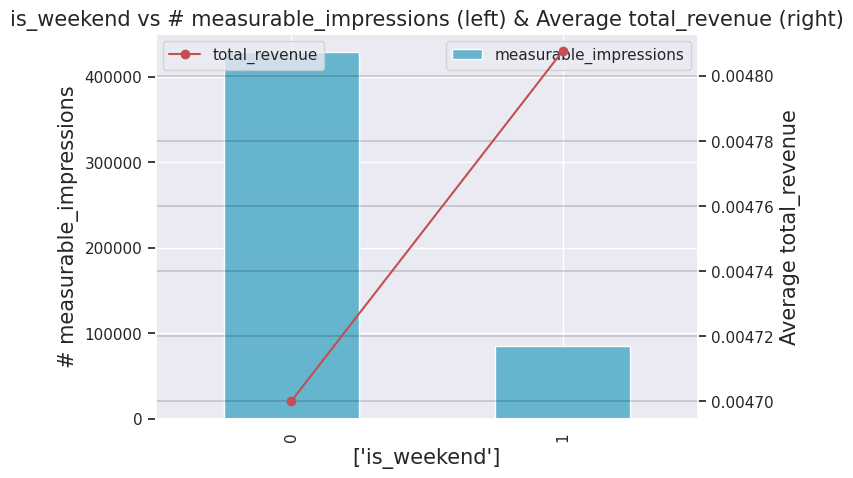

,is_weekend,total_revenue,measurable_impressions
0,0,0.0047,428719
1,1,0.0048,84450


In [ ]:
plot_dual_graph(x = ['is_weekend'], y1 = 'total_revenue', y2 = 'measurable_impressions', figsize=(7,5))

In [ ]:
ldf_ad_data["is_weekend"].value_counts(normalize=True)

,proportion
is_weekend,
0,0.8354
1,0.1646


is_weekend seems to share a varied distribution to the one we have with total_revenue i.e. 83% data is accumulated on weekdays!

**5.2 EDA of Remaining Variables**

For this part, we'll look at the distribution of all of the features by plotting them

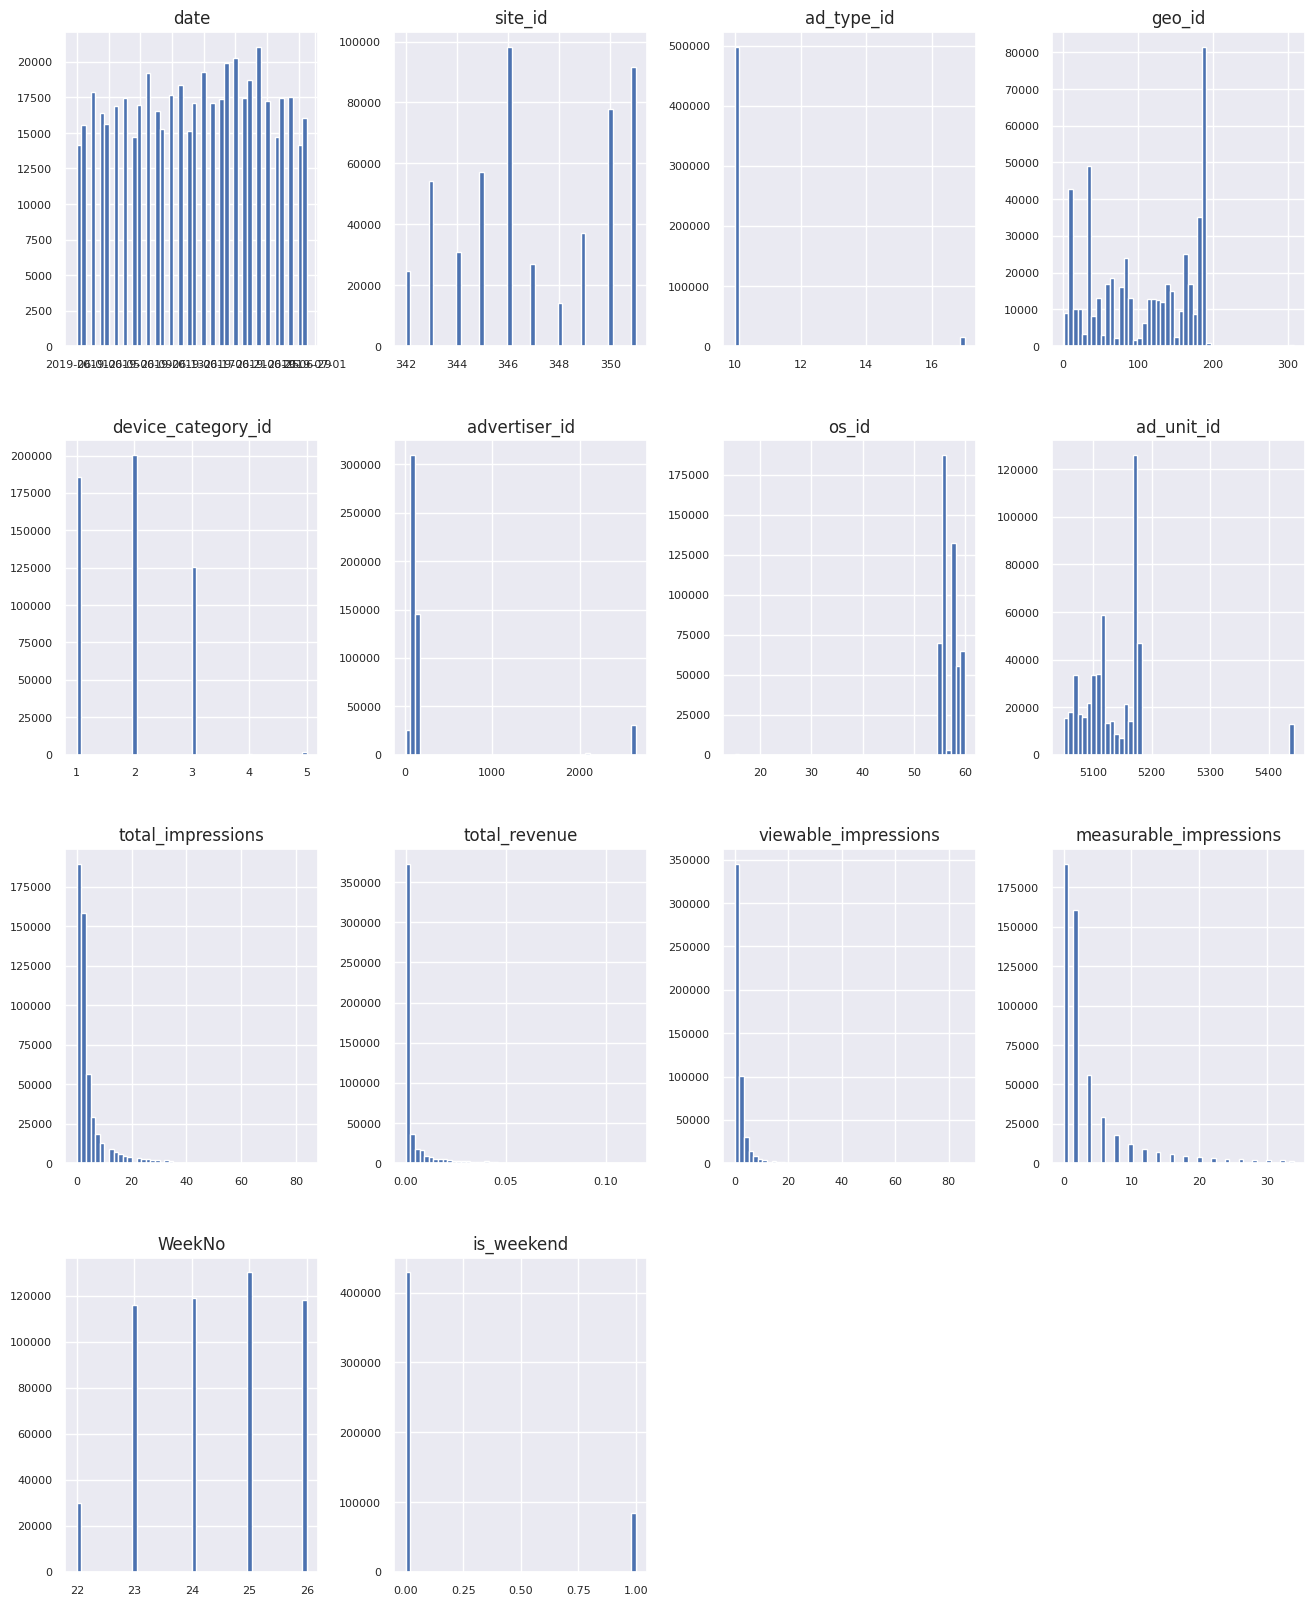

In [ ]:
ldf_ad_data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Features such as **site_id, ad_type_id, geo_id, device_category_id, ad_unit_id, week_no** etc. seems to share a similar distribution to the one we have with total_revenue.

**Correlation**

Now we'll try to find which features are strongly correlated with **total_revenue**. We'll store them in a var called **golden_features_list**. We'll reuse our **ldf_ad_data** dataset to do so.

In [ ]:
ldf_ad_data_corr = ldf_ad_data.corr()['total_revenue'][:-1] # -1 because the latest row is total_revenue
golden_features_list = ldf_ad_data_corr[abs(ldf_ad_data_corr) > 0.1].sort_values(ascending=False)
print("There is {} strongly correlated values with total_revenue:\n{}".format(len(golden_features_list), golden_features_list))

There is 5 strongly correlated values with total_revenue:
total_revenue                          1.0000
measurable_impressions                 0.4916
total_impressions                      0.4777
viewable_impressions                   0.3421
geo_id                                 0.1564
Name: total_revenue, dtype: float64


We now have a list of strongly correlated features.

However, correlation alone doesn't fully explain the nature of relationships between variables. Visualizing these relationships can reveal additional insights and help verify whether the correlated features have a linear relationship with **total_revenue**.

For instance, non-linear patterns like curvilinear relationships won’t be captured by correlation values alone. So, let’s take the features we previously excluded from the correlation table and plot them to see if any meaningful patterns emerge.

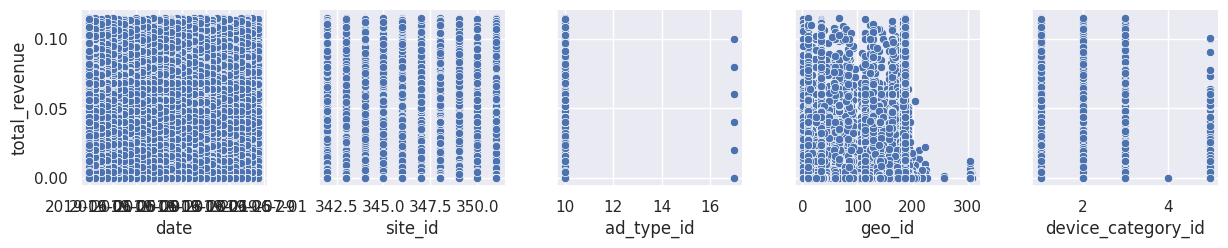

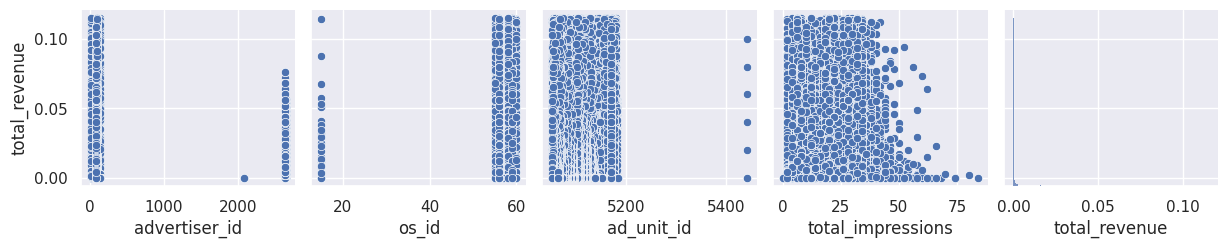

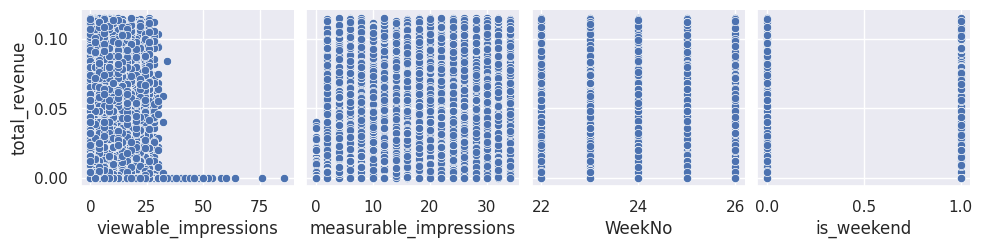

In [ ]:
for i in range(0, len(ldf_ad_data.columns), 5):
    sns.pairplot(data=ldf_ad_data,
                x_vars=ldf_ad_data.columns[i:i+5],
                y_vars=['total_revenue'])

**Insights**

By looking at correlation, we discovered 11 features that have a strong (or moderate) relationship to revenue.

Variables are as follows:

*   site_id
*   ad_type_id
*   geo_id
*   device_category_id
*   advertiser_id
*   os_id
*   ad_unit_id
* is_weekend

Also, impression variables are highly correlated (>70%) with total revenue

* viewable impressions
* Measurable impressions
* total impressions

# **6. Potential revenue range our publisher can make in July**
A good revenue model is a proven technique used by digital businesses globally, to generate income from traffic on their website, mobile apps, and via digital channels.

**The assumption is straightforward:** we'll calculate the total revenue and measurable impressions for each line item—but only for those that appear frequently (i.e., at least 5 occurrences).

Measurable impressions represent eligible impressions and are a key factor in revenue generation. Based on this, we’ll calculate the Click-Through Rate (CTR) as the ratio of measurable impressions to total impressions.

The reason for focusing on CTR is that, unlike many other relatively static features, CTR is expected to vary over time. This variability makes it an important factor in forecasting revenue.

**Algorithm**

* Group data by line item and calculate the sum of **total_impressions, measurable_impressions, and total_revenue**.

* Compute CTR: ***CTR = measurable_impressions / total_impressions***.

* Remove irrelevant columns and convert categorical columns into dummy variables.

* Split the data into training and testing sets.

* Train the model using the training data.

* Make predictions on the test data.

* Create two new CTR values: one increased by 5% (boosted) and one decreased by 5% (dropped).

* Predict revenue using the original, boosted, and dropped CTR values.

In [ ]:
# Prepare data for modelling.
# Group by line item - sum of total_impressions, measurable_impressions, total_revenue
ldf_grouped_ad_data = ldf_ad_data.groupby(["is_weekend", "site_id","ad_type_id", "geo_id","device_category_id",
                     "advertiser_id","os_id","ad_unit_id"])[["total_impressions","measurable_impressions","total_revenue"]].sum().reset_index()

# Below is the line item validator dataframe.
# Group by line item - count of any of these -- total_impressions, measurable_impressions, total_revenue
ldf_line_item_validator = ldf_ad_data.groupby(["is_weekend", "site_id","ad_type_id",
                     "geo_id","device_category_id",
                     "advertiser_id","os_id","ad_unit_id"])["total_revenue"].count().to_frame(name = 'count').reset_index()

ldf_grouped_ad_data = ldf_grouped_ad_data.merge(ldf_line_item_validator)

# Select data to be used for modelling i.e. line item combination should be greater than 5
# If count is less, treat them as a noise.
ldf_grouped_ad_data_to_be_modeled = ldf_grouped_ad_data[(ldf_grouped_ad_data['total_impressions']>0)&
                                          (ldf_grouped_ad_data['total_revenue']>0)&
                                         (ldf_grouped_ad_data['count']>5)]

# Store less frequent data in different data-frame
ldf_grouped_ad_data_to_be_ignored_in_modelling = ldf_grouped_ad_data[(ldf_grouped_ad_data['total_impressions']>0)&
                                          (ldf_ad_data['total_revenue']>0)&
                                         (ldf_grouped_ad_data['count']<=5)]

**Calculate CTR (CTR = measurable impression / total impression)**

In [ ]:
ldf_grouped_ad_data_to_be_modeled['CTR'] = ldf_grouped_ad_data_to_be_modeled.apply(lambda x: (x['measurable_impressions']/x['total_impressions'])*100, axis = 1)

**Drop unnecessary columns and create dummy variables of categorical column**

In [ ]:
# categorical column
cat_col=['is_weekend',
 'site_id',
 'ad_type_id',
 'geo_id',
 'device_category_id',
 'advertiser_id',
 'os_id',
 'ad_unit_id']

ldf_grouped_ad_data_to_be_modeled = pd.get_dummies(ldf_grouped_ad_data_to_be_modeled, columns=cat_col)
ldf_grouped_ad_data_to_be_modeled = ldf_grouped_ad_data_to_be_modeled.drop(['total_impressions','measurable_impressions','count'], axis=1)

**Create train-test split**

In [ ]:
from sklearn.model_selection import train_test_split

X=ldf_grouped_ad_data_to_be_modeled.drop(['total_revenue'], axis=1)
y=ldf_grouped_ad_data_to_be_modeled['total_revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=2)

**neural network 1**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
import pandas as pd


# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1) # Add a dimension for regression

# Split data into training and testing sets
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(
    X_tensor, y_tensor, test_size=0.25, random_state=42
)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Define the Neural Network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1) # Output layer for regression
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

# Instantiate the model, loss function, and optimizer
input_dimension = X_train_tensor.shape[1]
model = SimpleNN(input_dimension)
criterion = nn.MSELoss() # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
epochs = 50
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy().flatten() # Convert back to numpy and flatten
    y_true = y_test_tensor.numpy().flatten()
    # Ensure predictions are non-negative for MSLE
    y_pred = np.where(y_pred > 0, y_pred, 0)

    rmse = mean_squared_log_error(y_true, y_pred) ** 0.5
    print('The rmse of prediction is:', round(rmse, 5))


Epoch 1/50, Loss: 0.0044
Epoch 2/50, Loss: 0.0272
Epoch 3/50, Loss: 0.0098
Epoch 4/50, Loss: 0.0069
Epoch 5/50, Loss: 0.0007
Epoch 6/50, Loss: 0.0006
Epoch 7/50, Loss: 0.0003
Epoch 8/50, Loss: 0.0128
Epoch 9/50, Loss: 0.0040
Epoch 10/50, Loss: 0.0090
Epoch 11/50, Loss: 0.0144
Epoch 12/50, Loss: 0.0021
Epoch 13/50, Loss: 0.0010
Epoch 14/50, Loss: 0.0005
Epoch 15/50, Loss: 0.0012
Epoch 16/50, Loss: 0.0041
Epoch 17/50, Loss: 0.0010
Epoch 18/50, Loss: 0.0040
Epoch 19/50, Loss: 0.0063
Epoch 20/50, Loss: 0.1112
Epoch 21/50, Loss: 0.0070
Epoch 22/50, Loss: 0.0006
Epoch 23/50, Loss: 0.0146
Epoch 24/50, Loss: 0.0048
Epoch 25/50, Loss: 0.0032
Epoch 26/50, Loss: 0.0454
Epoch 27/50, Loss: 0.0047
Epoch 28/50, Loss: 0.0179
Epoch 29/50, Loss: 0.0045
Epoch 30/50, Loss: 0.0004
Epoch 31/50, Loss: 0.0005
Epoch 32/50, Loss: 0.0025
Epoch 33/50, Loss: 0.0083
Epoch 34/50, Loss: 0.0667
Epoch 35/50, Loss: 0.0050
Epoch 36/50, Loss: 0.0018
Epoch 37/50, Loss: 0.0036
Epoch 38/50, Loss: 0.0018
Epoch 39/50, Loss: 0.

In [ ]:
model.eval()

# Use torch.no_grad() as we don't need gradients for inference
with torch.no_grad():
    # We will apply the CTR changes and scaling to temporary DataFrames
    # to get the predictions, and then add the results back to
    # X_test_with_added_range

    # Create copies of the original X_test for modification and scaling
    X_test_raised_unscaled = X_test.copy()
    X_test_dropped_unscaled = X_test.copy()
    X_test_original_unscaled = X_test.copy() # Keep original for baseline prediction

    # Modify the 'CTR' column in the unscaled copies
    X_test_raised_unscaled['CTR'] = X_test_original_unscaled.apply(lambda x: x['CTR'] + 5 if x['CTR'] <= 95 else x['CTR'], axis=1)
    X_test_dropped_unscaled['CTR'] = X_test_original_unscaled.apply(lambda x: x['CTR'] - 5 if x['CTR'] >= 5 else x['CTR'], axis=1)

    # Scale the modified and original unscaled data
    X_test_raised_scaled = scaler.transform(X_test_raised_unscaled)
    X_test_dropped_scaled = scaler.transform(X_test_dropped_unscaled)
    X_test_original_scaled = scaler.transform(X_test_original_unscaled)


    # Convert scaled NumPy arrays to PyTorch tensors
    X_test_raised_tensor = torch.tensor(X_test_raised_scaled, dtype=torch.float32)
    X_test_dropped_tensor = torch.tensor(X_test_dropped_scaled, dtype=torch.float32)
    X_test_original_tensor = torch.tensor(X_test_original_scaled, dtype=torch.float32)

    # Get predictions using the forward pass
    llst_predicted_revenue_ctr_raised_5 = model(X_test_raised_tensor).numpy().flatten()
    llst_predicted_revenue_ctr_dropped_5 = model(X_test_dropped_tensor).numpy().flatten()
    llst_predicted_revenue_ctr_original = model(X_test_original_tensor).numpy().flatten()

    # Ensure predictions are non-negative
    llst_predicted_revenue_ctr_raised_5 = np.where(llst_predicted_revenue_ctr_raised_5 > 0, llst_predicted_revenue_ctr_raised_5, 0)
    llst_predicted_revenue_ctr_dropped_5 = np.where(llst_predicted_revenue_ctr_dropped_5 > 0, llst_predicted_revenue_ctr_dropped_5, 0)
    llst_predicted_revenue_ctr_original = np.where(llst_predicted_revenue_ctr_original > 0, llst_predicted_revenue_ctr_original, 0)


    # Recreate X_test_with_added_range with the original X_test data
    X_test_with_added_range = X_test.copy()

    # Calculate and add the new CTR columns based on the original X_test values
    X_test_with_added_range['CTR_Raised_5%'] = X_test.apply(lambda x: x['CTR']+5 if x['CTR']<=95 else x['CTR'], axis=1)
    X_test_with_added_range['CTR_Dropped_5%'] = X_test.apply(lambda x: x['CTR']-5 if x['CTR']>=5 else x['CTR'], axis=1) # Ensure CTR doesn't go below 0

    # Add the prediction columns
    X_test_with_added_range['Predicted_Revenue_CTR'] = llst_predicted_revenue_ctr_original
    X_test_with_added_range['Predicted_Revenue_CTR_Raised_5%'] = llst_predicted_revenue_ctr_raised_5
    X_test_with_added_range['Predicted_Revenue_CTR_Dropped_5%'] = llst_predicted_revenue_ctr_dropped_5

# It works as X_test_with_added_range has the correct columns
print("Actual Revenue in Current Month i.e. June (Test Data): "+str(sum(y_test)))

print("\nPredicted Revenue for Next Month i.e. July (Test Data):")
print("\nRevenue on CTR: "+str(sum(X_test_with_added_range['Predicted_Revenue_CTR'])))
print("Revenue on Boosted CTR: "+str(sum(X_test_with_added_range['Predicted_Revenue_CTR_Raised_5%'])))
print("Revenue on Dropped CTR: "+str(sum(X_test_with_added_range['Predicted_Revenue_CTR_Dropped_5%'])))

Actual Revenue in Current Month i.e. June (Test Data): 488.6293999999995

Predicted Revenue for Next Month i.e. July (Test Data):

Revenue on CTR: 445.48814671486616
Revenue on Boosted CTR: 445.65240912511945
Revenue on Dropped CTR: 428.2267169635743


In [ ]:
july_growth_rate = (sum(X_test_with_added_range['Predicted_Revenue_CTR_Raised_5%']) - sum(y_test))/sum(y_test)*100
print("Growth Rate: ","%.2f"%july_growth_rate)

Growth Rate:  -8.80


**upgraded neural network 1**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
import numpy as np
import pandas as pd


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

# Split into train and test
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(
    X_tensor, y_tensor, test_size=0.25, random_state=42
)

# Data loaders
batch_size = 4  # Experiment: try 4, 8, or 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.01),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

# ======== Initialize model and weights ========
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')
        nn.init.zeros_(m.bias)

input_dimension = X_train_tensor.shape[1]
model = SimpleNN(input_dimension)
model.apply(init_weights)

# ======== Define Loss and Optimizer ========
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Decay LR every 10 epochs

# ======== Training Loop ========
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)

    scheduler.step()
    avg_loss = epoch_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.6f}")

# ======== Evaluation ========
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy().flatten()
    y_true = y_test_tensor.numpy().flatten()
    y_pred = np.where(y_pred > 0, y_pred, 0)  # Ensure non-negative for MSLE
    rmse = mean_squared_log_error(y_true, y_pred) ** 0.5
    print('The RMSE of prediction is:', round(rmse, 5))


Epoch 1/50, Avg Loss: 0.390778
Epoch 2/50, Avg Loss: 0.246354
Epoch 3/50, Avg Loss: 0.186583
Epoch 4/50, Avg Loss: 0.155421
Epoch 5/50, Avg Loss: 0.133618
Epoch 6/50, Avg Loss: 0.117257
Epoch 7/50, Avg Loss: 0.110824
Epoch 8/50, Avg Loss: 0.107312
Epoch 9/50, Avg Loss: 0.100295
Epoch 10/50, Avg Loss: 0.086379
Epoch 11/50, Avg Loss: 0.084894
Epoch 12/50, Avg Loss: 0.082074
Epoch 13/50, Avg Loss: 0.074648
Epoch 14/50, Avg Loss: 0.074303
Epoch 15/50, Avg Loss: 0.064020
Epoch 16/50, Avg Loss: 0.072487
Epoch 17/50, Avg Loss: 0.065535
Epoch 18/50, Avg Loss: 0.059920
Epoch 19/50, Avg Loss: 0.056694
Epoch 20/50, Avg Loss: 0.062811
Epoch 21/50, Avg Loss: 0.056619
Epoch 22/50, Avg Loss: 0.054596
Epoch 23/50, Avg Loss: 0.056774
Epoch 24/50, Avg Loss: 0.050003
Epoch 25/50, Avg Loss: 0.058384
Epoch 26/50, Avg Loss: 0.051949
Epoch 27/50, Avg Loss: 0.049731
Epoch 28/50, Avg Loss: 0.056764
Epoch 29/50, Avg Loss: 0.048506
Epoch 30/50, Avg Loss: 0.048025
Epoch 31/50, Avg Loss: 0.052530
Epoch 32/50, Avg 

In [ ]:
model.eval()

# Use torch.no_grad() as we don't need gradients for inference
with torch.no_grad():
    # We will apply the CTR changes and scaling to temporary DataFrames
    # to get the predictions, and then add the results back to
    # X_test_with_added_range

    # Create copies of the original X_test for modification and scaling
    X_test_raised_unscaled = X_test.copy()
    X_test_dropped_unscaled = X_test.copy()
    X_test_original_unscaled = X_test.copy() # Keep original for baseline prediction

    # Modify the 'CTR' column in the unscaled copies
    X_test_raised_unscaled['CTR'] = X_test_original_unscaled.apply(lambda x: x['CTR'] + 5 if x['CTR'] <= 95 else x['CTR'], axis=1)
    X_test_dropped_unscaled['CTR'] = X_test_original_unscaled.apply(lambda x: x['CTR'] - 5 if x['CTR'] >= 5 else x['CTR'], axis=1)

    # Scale the modified and original unscaled data
    X_test_raised_scaled = scaler.transform(X_test_raised_unscaled)
    X_test_dropped_scaled = scaler.transform(X_test_dropped_unscaled)
    X_test_original_scaled = scaler.transform(X_test_original_unscaled)


    # Convert scaled NumPy arrays to PyTorch tensors
    X_test_raised_tensor = torch.tensor(X_test_raised_scaled, dtype=torch.float32)
    X_test_dropped_tensor = torch.tensor(X_test_dropped_scaled, dtype=torch.float32)
    X_test_original_tensor = torch.tensor(X_test_original_scaled, dtype=torch.float32)

    # Get predictions using the forward pass
    llst_predicted_revenue_ctr_raised_5 = model(X_test_raised_tensor).numpy().flatten()
    llst_predicted_revenue_ctr_dropped_5 = model(X_test_dropped_tensor).numpy().flatten()
    llst_predicted_revenue_ctr_original = model(X_test_original_tensor).numpy().flatten()

    # Ensure predictions are non-negative
    llst_predicted_revenue_ctr_raised_5 = np.where(llst_predicted_revenue_ctr_raised_5 > 0, llst_predicted_revenue_ctr_raised_5, 0)
    llst_predicted_revenue_ctr_dropped_5 = np.where(llst_predicted_revenue_ctr_dropped_5 > 0, llst_predicted_revenue_ctr_dropped_5, 0)
    llst_predicted_revenue_ctr_original = np.where(llst_predicted_revenue_ctr_original > 0, llst_predicted_revenue_ctr_original, 0)


    # Recreate X_test_with_added_range with the original X_test data
    X_test_with_added_range = X_test.copy()

    # Calculate and add the new CTR columns based on the original X_test values
    X_test_with_added_range['CTR_Raised_5%'] = X_test.apply(lambda x: x['CTR']+5 if x['CTR']<=95 else x['CTR'], axis=1)
    X_test_with_added_range['CTR_Dropped_5%'] = X_test.apply(lambda x: x['CTR']-5 if x['CTR']>=5 else x['CTR'], axis=1) # Ensure CTR doesn't go below 0

    # Add the prediction columns
    X_test_with_added_range['Predicted_Revenue_CTR'] = llst_predicted_revenue_ctr_original
    X_test_with_added_range['Predicted_Revenue_CTR_Raised_5%'] = llst_predicted_revenue_ctr_raised_5
    X_test_with_added_range['Predicted_Revenue_CTR_Dropped_5%'] = llst_predicted_revenue_ctr_dropped_5

# It works as X_test_with_added_range has the correct columns
print("Actual Revenue in Current Month i.e. June (Test Data): "+str(sum(y_test)))

print("\nPredicted Revenue for Next Month i.e. July (Test Data):")
print("\nRevenue on CTR: "+str(sum(X_test_with_added_range['Predicted_Revenue_CTR'])))
print("Revenue on Boosted CTR: "+str(sum(X_test_with_added_range['Predicted_Revenue_CTR_Raised_5%'])))
print("Revenue on Dropped CTR: "+str(sum(X_test_with_added_range['Predicted_Revenue_CTR_Dropped_5%'])))

Actual Revenue in Current Month i.e. June (Test Data): 488.6293999999995

Predicted Revenue for Next Month i.e. July (Test Data):

Revenue on CTR: 452.0517179183662
Revenue on Boosted CTR: 452.6459923684597
Revenue on Dropped CTR: 438.557166043669


In [ ]:
july_growth_rate = (sum(X_test_with_added_range['Predicted_Revenue_CTR_Raised_5%']) - sum(y_test))/sum(y_test)*100
print("Growth Rate: ","%.2f"%july_growth_rate)

Growth Rate:  -7.36


**xgboost**

**Fit the model, Predict on testing data, & Calculate rmse value**

In [ ]:
from xgboost import XGBRegressor # Example for XGBoost
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

# Instantiate the Model: Create an instance of the chosen model.
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=0)

# Train the Model: Use the `fit()` method with your training data.
model.fit(X_train, y_train)

# Make Predictions: Use the `predict()` method to get predictions on your test data.
y_pred = model.predict(X_test)

# Evaluate the Model: Use appropriate regression metrics to evaluate the performance of the new model.
print('The rmse of prediction is:', round(mean_squared_log_error(y_test, y_pred) ** 0.5, 5)) # Note: Corrected order of y_test and y_pred

The rmse of prediction is: 0.13864


In [ ]:
X_test_with_added_range = X_test.copy()

X_test_with_added_range['CTR_Raised_5%'] = X_test.apply(lambda x: x['CTR']+5 if x['CTR']<=95 else x['CTR'], axis=1)
X_test_with_added_range['CTR_Dropped_5%'] = X_test.apply(lambda x: x['CTR']-5, axis=1)

In [ ]:
X_test_with_added_range = X_test.copy()

X_test_with_added_range['CTR'] = X_test.apply(lambda x: x['CTR'] + 5 if x['CTR']<=95 else x['CTR'], axis=1)
llst_predicted_revenue_ctr_raised_5 = model.predict(X_test_with_added_range)

X_test_with_added_range['CTR'] = X_test.apply(lambda x: x['CTR'] - 5 if x['CTR']>=5 else x['CTR'], axis=1)
llst_predicted_revenue_ctr_dropped_5 = model.predict(X_test_with_added_range)

X_test_with_added_range['CTR'] = X_test['CTR']
X_test_with_added_range['CTR_Raised_5%'] = X_test.apply(lambda x: x['CTR']+5 if x['CTR']<=95 else x['CTR'], axis=1)
X_test_with_added_range['CTR_Dropped_5%'] = X_test.apply(lambda x: x['CTR']-5, axis=1)
X_test_with_added_range['Predicted_Revenue_CTR'] = model.predict(X_test)
X_test_with_added_range['Predicted_Revenue_CTR_Raised_5%'] = llst_predicted_revenue_ctr_raised_5
X_test_with_added_range['Predicted_Revenue_CTR_Dropped_5%'] = llst_predicted_revenue_ctr_dropped_5

In [ ]:
X_test_with_added_range.tail()

,CTR,is_weekend_0,is_weekend_1,site_id_342,site_id_343,site_id_344,site_id_345,site_id_346,site_id_347,site_id_348,...,ad_unit_id_5178,ad_unit_id_5179,ad_unit_id_5180,ad_unit_id_5181,ad_unit_id_5443,CTR_Raised_5%,CTR_Dropped_5%,Predicted_Revenue_CTR,Predicted_Revenue_CTR_Raised_5%,Predicted_Revenue_CTR_Dropped_5%
42142,100.0000,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,100.0000,95.0000,0.0504,0.0504,0.2003
9775,90.9091,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,95.9091,85.9091,0.1748,0.2302,0.1006
57422,100.0000,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,100.0000,95.0000,0.0067,0.0067,0.0447
10424,100.0000,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,100.0000,95.0000,0.0310,0.0310,0.0683
1827,96.1538,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,96.1538,91.1538,0.1140,0.1140,0.0585


**Forecasting using XGboost for July Month**

In [ ]:
print("Actual Revenue in Current Month i.e. June (Test Data): "+str(sum(y_test)))

print("\nPredicted Revenue for Next Month i.e. July (Test Data):")
print("\nRevenue on CTR: "+str(sum(X_test_with_added_range['Predicted_Revenue_CTR'])))
print("Revenue on Boosted CTR: "+str(sum(X_test_with_added_range['Predicted_Revenue_CTR_Raised_5%'])))
print("Revenue on Dropped CTR: "+str(sum(X_test_with_added_range['Predicted_Revenue_CTR_Dropped_5%'])))

Actual Revenue in Current Month i.e. June (Test Data): 488.6293999999995

Predicted Revenue for Next Month i.e. July (Test Data):

Revenue on CTR: 511.30409279720334
Revenue on Boosted CTR: 532.9805385286891
Revenue on Dropped CTR: 527.7002381469938


In [ ]:
july_growth_rate = (sum(X_test_with_added_range['Predicted_Revenue_CTR_Raised_5%']) - sum(y_test))/sum(y_test)*100
print("Growth Rate: ","%.2f"%july_growth_rate)

Growth Rate:  9.08


**RandomForest**

**Fit the model**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=2, random_state=0)

regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

**Predict on testing data**

In [ ]:
y_pred = regr.predict(X_test)
y_pred = np.where(y_pred>0, y_pred, 0)

**Calculate rmse value**

In [ ]:
from sklearn.metrics import mean_squared_log_error
print('The rmse of prediction is:', round(mean_squared_log_error(y_test, y_pred) ** 0.5, 5))

The rmse of prediction is: 0.18057


**Now, using CTR let's create two more columns with boosted & dropped value of CTR by 5%**

In [ ]:
X_test_with_added_range = X_test.copy()

X_test_with_added_range['CTR_Raised_5%'] = X_test.apply(lambda x: x['CTR']+5 if x['CTR']<=95 else x['CTR'], axis=1)
X_test_with_added_range['CTR_Dropped_5%'] = X_test.apply(lambda x: x['CTR']-5, axis=1)

**Predict on three values on CTR - Original, Boosted(+5%) & Dropped(-5%)**

In [ ]:
X_test_with_added_range = X_test.copy()

X_test_with_added_range['CTR'] = X_test.apply(lambda x: x['CTR'] + 5 if x['CTR']<=95 else x['CTR'], axis=1)
llst_predicted_revenue_ctr_raised_5 = regr.predict(X_test_with_added_range)

X_test_with_added_range['CTR'] = X_test.apply(lambda x: x['CTR'] - 5 if x['CTR']>=5 else x['CTR'], axis=1)
llst_predicted_revenue_ctr_dropped_5 = regr.predict(X_test_with_added_range)

X_test_with_added_range['CTR'] = X_test['CTR']
X_test_with_added_range['CTR_Raised_5%'] = X_test.apply(lambda x: x['CTR']+5 if x['CTR']<=95 else x['CTR'], axis=1)
X_test_with_added_range['CTR_Dropped_5%'] = X_test.apply(lambda x: x['CTR']-5, axis=1)
X_test_with_added_range['Predicted_Revenue_CTR'] = regr.predict(X_test)
X_test_with_added_range['Predicted_Revenue_CTR_Raised_5%'] = llst_predicted_revenue_ctr_raised_5
X_test_with_added_range['Predicted_Revenue_CTR_Dropped_5%'] = llst_predicted_revenue_ctr_dropped_5

In [ ]:
X_test_with_added_range.tail()

,CTR,is_weekend_0,is_weekend_1,site_id_342,site_id_343,site_id_344,site_id_345,site_id_346,site_id_347,site_id_348,...,ad_unit_id_5178,ad_unit_id_5179,ad_unit_id_5180,ad_unit_id_5181,ad_unit_id_5443,CTR_Raised_5%,CTR_Dropped_5%,Predicted_Revenue_CTR,Predicted_Revenue_CTR_Raised_5%,Predicted_Revenue_CTR_Dropped_5%
42142,100.0000,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,100.0000,95.0000,0.1848,0.1848,0.1858
9775,90.9091,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,95.9091,85.9091,0.5443,0.5443,0.5443
57422,100.0000,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,100.0000,95.0000,0.0855,0.0855,0.0865
10424,100.0000,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,100.0000,95.0000,0.0855,0.0855,0.0865
1827,96.1538,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,96.1538,91.1538,0.0865,0.0865,0.0865


**Forecasting using random forest for July Month**

In [ ]:
print("Actual Revenue in Current Month i.e. June (Test Data): "+str(sum(y_test)))

print("\nPredicted Revenue for Next Month i.e. July (Test Data):")
print("\nRevenue on CTR: "+str(sum(X_test_with_added_range['Predicted_Revenue_CTR'])))
print("Revenue on Boosted CTR: "+str(sum(X_test_with_added_range['Predicted_Revenue_CTR_Raised_5%'])))
print("Revenue on Dropped CTR: "+str(sum(X_test_with_added_range['Predicted_Revenue_CTR_Dropped_5%'])))

Actual Revenue in Current Month i.e. June (Test Data): 488.6293999999995

Predicted Revenue for Next Month i.e. July (Test Data):

Revenue on CTR: 547.5412002547148
Revenue on Boosted CTR: 547.5351821825287
Revenue on Dropped CTR: 549.4178357647615


In [ ]:
july_growth_rate = (sum(X_test_with_added_range['Predicted_Revenue_CTR_Raised_5%']) - sum(y_test))/sum(y_test)*100
print("Growth Rate: ","%.2f"%july_growth_rate)

Growth Rate:  12.06


# **Result Summary**

**What is the potential revenue range our publisher can make in July?**

We evaluated four models—Simple Neural Network (NN), Upgraded Simple NN, XGBoost, and Random Forest—to forecast July revenue based on CTR variations.

**1. Simple NN**

* RMSE: 0.1653
* Predicted Revenue (CTR): 445.49
* Boosted CTR (+5%): 445.65
* Dropped CTR (–5%): 428.23
* Growth Rate: –8.80%

**2. Upgraded Simple NN**

* RMSE: 0.09579 (Best accuracy among all)
* Predicted Revenue (CTR): 452.05
* Boosted CTR (+5%): 452.65
* Dropped CTR (–5%): 438.56
* Growth Rate: –7.36%

**3. XGBoost**

* RMSE: 0.13864
* Predicted Revenue (CTR): 511.30
* Boosted CTR (+5%): 532.98
* Dropped CTR (–5%): 527.70
* Growth Rate: +9.08%

**4. Random Forest**

* RMSE: 0.18057
* Predicted Revenue (CTR): 547.54
* Boosted CTR (+5%): 547.54
* Dropped CTR (–5%): 549.42
* Growth Rate: +12.06%

**Potential Revenue Range for July:**

Based on all models and CTR variations:

Lowest Forecasted Revenue: **428.23 (Simple NN with Dropped CTR)**

Highest Forecasted Revenue: **549.42 (Random Forest with Dropped CTR)**

📈 Estimated Revenue Range: **428 – 549**

# **7. The reserve prices that he/she can set**

To determine the optimal reserve price, I’ve based my assumptions on CPM (Cost Per Mille), which has a linear relationship with bids or price. CPM is calculated as:

**CPM = (Revenue / Impressions) × 1000**

In simple terms, CPM reflects the price or bid value per 1,000 impressions. By analyzing the CPM of a particular line item, we can estimate the price at which it typically wins bids. This makes CPM a useful metric for setting an optimal reserve price.

**7.1 Determine Optimal Reserve Price**

Step 1. Get total measusable_impressions & total_revenue per line item i.e. group by above features and get sum(measusable_impressions) & sum(total_revenue)

Step 2. Now, we will apply the CPM formula on newly created columns and create a new column which is CPM.

In [ ]:
ldf_grouped_ad_data = ldf_ad_data.groupby(["is_weekend", "site_id","ad_type_id",
                     "geo_id","device_category_id",
                     "advertiser_id","os_id","ad_unit_id"])[["measurable_impressions","total_revenue"]].sum().reset_index() # Changed tuple to list

In [ ]:
ldf_grouped_ad_data.shape

(91574, 10)

In [ ]:
ldf_grouped_ad_data.describe()

,is_weekend,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,os_id,ad_unit_id,measurable_impressions,total_revenue,cpm/reserve_price
count,"91,574.0000","91,574.0000","91,574.0000","91,574.0000","91,574.0000","91,574.0000","91,574.0000","91,574.0000","91,574.0000","91,574.0000","91,574.0000"
mean,0.3378,346.7380,10.2279,101.8062,1.9437,275.6568,57.1691,"5,132.2748",20.5490,0.0264,0.5687
std,0.4729,2.8976,1.2425,60.4044,0.8028,643.7672,2.2161,64.6270,140.6948,0.1904,1.4160
min,0.0000,342.0000,10.0000,1.0000,1.0000,8.0000,15.0000,"5,050.0000",0.0000,0.0000,0.0000
25%,0.0000,345.0000,10.0000,46.0000,1.0000,79.0000,56.0000,"5,097.0000",0.0000,0.0000,0.0000
50%,0.0000,346.0000,10.0000,99.0000,2.0000,90.0000,57.0000,"5,119.0000",2.0000,0.0000,0.0000
75%,1.0000,349.0000,10.0000,160.0000,3.0000,139.0000,58.0000,"5,168.0000",8.0000,0.0036,0.5000
max,1.0000,351.0000,17.0000,308.0000,5.0000,"2,646.0000",60.0000,"5,443.0000","17,820.0000",23.0186,52.2000


**Calculate CPM - Cost Per Mille**

In [ ]:
def calculate_cpm(n, d):
    """
    CPM – cost per Mille. This is one of the most important ways to measure
    performance. It is. Calculated as revenue/impressions * 1000. 'bids' and 'price' are
    measured in terms of CPM
    """
    return (n / d)*1000 if d else 0

In [ ]:
ldf_grouped_ad_data['cpm/reserve_price'] = ldf_grouped_ad_data.apply(lambda x: calculate_cpm(((x['total_revenue'])),x['measurable_impressions']) , axis=1)

In [ ]:
ldf_grouped_ad_data.describe()

,is_weekend,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,os_id,ad_unit_id,measurable_impressions,total_revenue,cpm/reserve_price
count,"91,574.0000","91,574.0000","91,574.0000","91,574.0000","91,574.0000","91,574.0000","91,574.0000","91,574.0000","91,574.0000","91,574.0000","91,574.0000"
mean,0.3378,346.7380,10.2279,101.8062,1.9437,275.6568,57.1691,"5,132.2748",20.5490,0.0264,0.5687
std,0.4729,2.8976,1.2425,60.4044,0.8028,643.7672,2.2161,64.6270,140.6948,0.1904,1.4160
min,0.0000,342.0000,10.0000,1.0000,1.0000,8.0000,15.0000,"5,050.0000",0.0000,0.0000,0.0000
25%,0.0000,345.0000,10.0000,46.0000,1.0000,79.0000,56.0000,"5,097.0000",0.0000,0.0000,0.0000
50%,0.0000,346.0000,10.0000,99.0000,2.0000,90.0000,57.0000,"5,119.0000",2.0000,0.0000,0.0000
75%,1.0000,349.0000,10.0000,160.0000,3.0000,139.0000,58.0000,"5,168.0000",8.0000,0.0036,0.5000
max,1.0000,351.0000,17.0000,308.0000,5.0000,"2,646.0000",60.0000,"5,443.0000","17,820.0000",23.0186,52.2000


**7.2 Result Summary**

Unlike real-life bid values, the derived reserve prices here represent the minimum amount a publisher should accept to avoid losing revenue from low bids. Setting this threshold encourages higher bidding, ultimately boosting publisher revenue.

As shown in the table above, most bidding prices consistently fall within the **30 to 50 cents** range. This supports the validity of our assumptions and indicates that the derived reserve prices are reasonable.

# **8. Conclusion**

Digital markets are still catching up to other industries in adopting AI, but there is significant potential to benefit from an AI-first approach. The proposed solution shows promise in delivering valuable outcomes for publishers.


Reflections and Limitations

**Data Volume:**
Only one month of data was available for forecasting, which is likely insufficient to fully support the conclusions drawn.

**Time Constraints:**
The entire solution was developed within two days. Strong skills in analytics and tools like Python, Pandas, and Jupyter Notebook helped accelerate the process. Increasing domain knowledge upfront would further improve efficiency and results.



**End of Notebook here...**